# Autoencoder v4
Re-implemented v3 with the following changes:
1. Train dataset of 600 models
2. Test dataset (also used for validation) of 200 models
3. Another dataset of 200 models (which is new to the model) for checking if the model works well on unseen data

### Importing all necessary libraries

In [1]:
import numpy as np
import tensorflow as tf
from keras.layers import Input, Conv3D, UpSampling3D, AveragePooling3D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import numpy as np
import pandas as pd
from pyntcloud import PyntCloud
import open3d as o3d
from ConversionUtils import ConversionUtils
from Visualization import Visualization

2023-11-02 20:22:59.615050: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-02 20:22:59.615106: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-02 20:22:59.620894: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-02 20:23:00.426026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/hrishi/Miniconda3/envs/tensorflow/lib/python

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### Converting STL to point cloud

**Execute the following cell if you wish to delete all existing point cloud files in abc-dataset-ply/ directory**

In [ ]:
folder_path = "abc-dataset-ply/"
files = os.listdir(folder_path)

for file in files:
    file_path = os.path.join(folder_path, file)
    if os.path.isfile(file_path):
        try:
            os.remove(file_path)
        except Exception as e:
            print(f"Error deleting {file}: {str(e)}")

**Only execute the next cell if the point cloud files do not exist in abc-dataset-ply/ directory**

In [ ]:
files = sorted(ConversionUtils.list_files_in_directory("abc-dataset-stl/"))
for i in files:
    path = "abc-dataset-stl/" + i
    ConversionUtils.stl_to_ply(path, 20000)

### Converting point cloud to binary voxel arrays

In [2]:
directory = "abc-dataset-ply/"
# Taking first 1000 models
files = sorted([filename for filename in os.listdir(directory) if os.path.isfile(os.path.join(directory, filename))])
dataset = []

for i in files:
    path = os.path.join(directory, i)
    binvox = ConversionUtils.convert_to_binvox(path, 64)
    dataset.append(binvox)

In [3]:
print(len(dataset))

1000


### Splitting dataset for training and testing

In [4]:
# Load your dataset into numpy arrays
dataset = np.array(dataset)

# Split your dataset into train and test datasets
train_dataset = dataset[:600]  # Adjust the number as needed
test_dataset = dataset[600:800]
new_dataset = dataset[800:]   # The remaining data for testing
print(len(train_dataset), len(test_dataset), len(new_dataset))
# Define the input shape
input_shape = (64, 64, 64, 1)

600 200 200


### Encoder

In [5]:
input_data = Input(shape=input_shape)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(input_data)
x = AveragePooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(x)
encoded = AveragePooling3D((2, 2, 2), padding='same')(x)

2023-11-02 20:24:31.055100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 20:24:31.735996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-02 20:24:31.736411: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### Decoder

In [6]:
x = Conv3D(16, (3, 3, 3), activation='selu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(32, (3, 3, 3), activation='selu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(x)

### Callbacks

#### Early Stopping

In [7]:
early_stopping = EarlyStopping(
    monitor="loss",
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode="min",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0,
)

#### Checkpoint

In [8]:
checkpoint_filepath = 'checkpoints/v4/checkpoint'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

### Training autoencoder, prediction done on test dataset

In [9]:
autoencoder = Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder.fit(train_dataset, train_dataset, epochs=50, batch_size=10, validation_data=(train_dataset, train_dataset), callbacks=[early_stopping, model_checkpoint_callback])

2023-11-02 20:24:40.390679: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2023-11-02 20:24:41.097857: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2023-11-02 20:24:41.624350: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.
2023-11-02 20:24:41.719722: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.


Epoch 1/50


2023-11-02 20:24:44.388793: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-02 20:24:55.125824: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f46ad922720 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-02 20:24:55.125859: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-11-02 20:24:55.258202: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-02 20:24:55.776499: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.9677

2023-11-02 20:25:14.738507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 629145600 exceeds 10% of free system memory.


60/60 [==============================] - 41s 426ms/step - loss: 0.1292 - accuracy: 0.9677 - val_loss: 0.0588 - val_accuracy: 0.9744
Epoch 2/50
60/60 [==============================] - 22s 362ms/step - loss: 0.0518 - accuracy: 0.9762 - val_loss: 0.0501 - val_accuracy: 0.9770
Epoch 3/50
60/60 [==============================] - 22s 364ms/step - loss: 0.0469 - accuracy: 0.9774 - val_loss: 0.0446 - val_accuracy: 0.9781
Epoch 4/50
60/60 [==============================] - 22s 366ms/step - loss: 0.0440 - accuracy: 0.9785 - val_loss: 0.0432 - val_accuracy: 0.9800
Epoch 5/50
60/60 [==============================] - 22s 365ms/step - loss: 0.0415 - accuracy: 0.9797 - val_loss: 0.0402 - val_accuracy: 0.9803
Epoch 6/50
60/60 [==============================] - 22s 366ms/step - loss: 0.0394 - accuracy: 0.9810 - val_loss: 0.0378 - val_accuracy: 0.9818
Epoch 7/50
60/60 [==============================] - 22s 366ms/step - loss: 0.0364 - accuracy: 0.9827 - val_loss: 0.0346 - val_accuracy: 0.9838
Epoch 8/50

In [10]:
reconstructed_data = autoencoder.predict(new_dataset, batch_size=10)

20/20 [==============================] - 2s 86ms/step


In [51]:
tf.keras.backend.clear_session()

In [52]:
evaluation = autoencoder.evaluate(new_dataset, new_dataset, verbose=1)

7/7 [==============================] - 5s 380ms/step - loss: 0.0130 - accuracy: 0.9946


In [12]:
encoder = Model(autoencoder.input, autoencoder.layers[5].output)
encoded_data = encoder.predict(new_dataset, batch_size=10)

20/20 [==============================] - 1s 30ms/step


### Saving autoencoder and encoder

In [14]:
autoencoder.save("saved-models/v4/autoencoder-v4.keras")
encoder.save("saved-models/v4/encoder-v4.keras")

### Dimensions

In [15]:
print("Shape of input data: ", new_dataset[0].shape)
print("Shape of encoded data: ", encoded_data[0].shape)
print("Shape of reconstructed data: ", reconstructed_data[0].shape)

Shape of input data:  (64, 64, 64)
Shape of encoded data:  (16, 16, 16, 16)
Shape of reconstructed data:  (64, 64, 64, 1)


### Sample reconstruction from test dataset

In [42]:
import matplotlib.pyplot as plt

index = 55

original_sample = new_dataset[index]

reconstructed_sample = reconstructed_data[index].reshape(64, 64, 64)
threshold = 0.35
reconstructed_sample = (reconstructed_sample > threshold).astype(int)

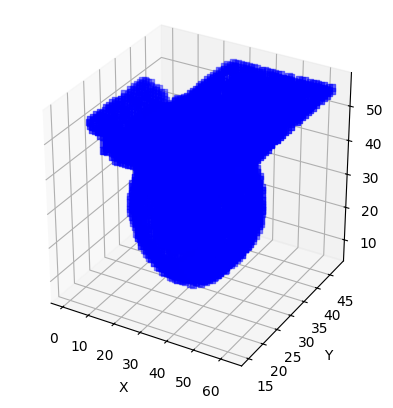

In [43]:
Visualization.matplotlib_visualize_original(original_sample)

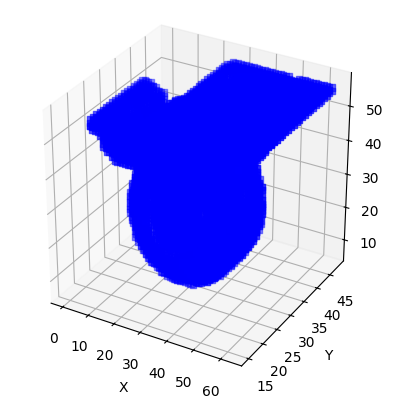

In [44]:
Visualization.matplotlib_visualize_reconstructed(reconstructed_sample)

In [45]:
path = "sample-outputs/v4/" + "original-" + str(index) + ".ply"
Visualization.open3d_visualize_original(original_sample, path)

In [46]:
path = "sample-outputs/v4/" + "reconstructed-" + str(index) + ".ply"
Visualization.open3d_visualize_reconstructed(reconstructed_sample, path)

### Visualizing encoded data

In [47]:
sample_encoded_data = encoded_data[index]
print(sample_encoded_data.shape)

(16, 16, 16, 16)


In [48]:
print(sample_encoded_data)

[[[[-0.2076238  -0.2369252  -0.17569555 ... -0.1696419  -0.2511299
    -0.23013666]
   [-0.21905701 -0.25244927 -0.16735832 ... -0.15665601 -0.22377221
    -0.2544487 ]
   [-0.21724659 -0.24976784 -0.16023587 ... -0.16607043 -0.22021653
    -0.25884426]
   ...
   [-0.21724659 -0.24976784 -0.16023587 ... -0.16607043 -0.22021653
    -0.25884426]
   [-0.21453615 -0.24068464 -0.1518083  ... -0.16596843 -0.21086603
    -0.25581074]
   [-0.18647836 -0.27587923 -0.15225874 ... -0.15078852 -0.13012445
    -0.21395905]]

  [[-0.22792977 -0.22365779 -0.21022227 ... -0.18424766 -0.24076207
    -0.24225266]
   [-0.26558268 -0.26475847 -0.2196904  ... -0.18160157 -0.21432595
    -0.25344068]
   [-0.2674239  -0.25787866 -0.21631408 ... -0.19304967 -0.20349377
    -0.25665602]
   ...
   [-0.2674239  -0.25787866 -0.21631408 ... -0.19304967 -0.20349377
    -0.25665602]
   [-0.26162055 -0.25270787 -0.20280714 ... -0.19687589 -0.1870584
    -0.25228894]
   [-0.25657022 -0.28168318 -0.20089799 ... -0.1650

In [49]:
threshold = 0.35
binary_arrays = (sample_encoded_data >= threshold).astype(int)
print(binary_arrays)

[[[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  ...

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]]


 [[[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   ...
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]]

  [[0 0 0 ... 0 0 0]
   [0 0 0 ... 0 0 0]
   [

/tmp/ipykernel_9456/4175828760.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(binary_arrays))
/tmp/ipykernel_9456/4175828760.py:12: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x, y, z, c=colors(i), marker='o', s=20, label=f'Channel {i + 1}')


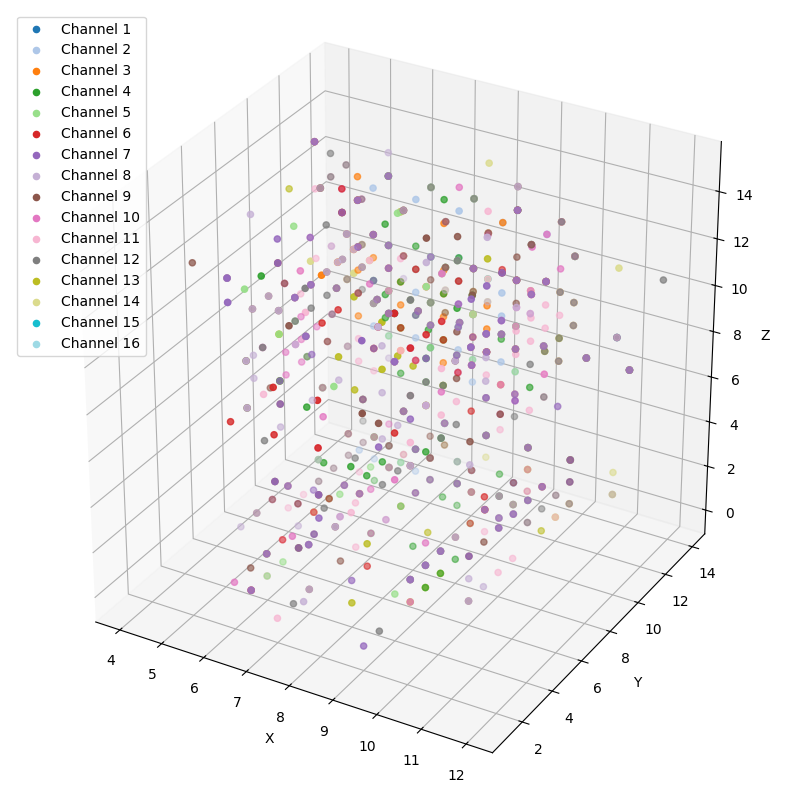

In [50]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.get_cmap('tab20', len(binary_arrays))

for i, binary_array in enumerate(binary_arrays):
    x, y, z = np.where(binary_array == 1)
    ax.scatter(x, y, z, c=colors(i), marker='o', s=20, label=f'Channel {i + 1}')

ax.set_box_aspect([1, 1, 1])

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.legend()

plt.show()